# Park Visitation and Meteorological Relationships
a. stein 3.10.22

Examine relationships and potential for correlation between park visitation data and meteorological data, (currently precipitation, max air temperature, minimum air temperature).

In [212]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd
import contextily as cx
from tqdm.autonotebook import tqdm

import rioxarray
from shapely.geometry import mapping

import sys
sys.path.append('../../')
import sedi.wrangle as wrangle

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


Load in Park Data

In [2]:
park_path = '/pool0/home/steinadi/data/drought/drought_impact/data/socio-econ'

nat_park_visits = xr.open_dataset(f'{park_path}/national_parks_or_wa.nc')

Need to real quick get rid of that one park in Alaska

nat_parks = list(nat_park_visits.park.values)
del nat_parks[2]
nat_parks

nat_park_visits.sel(park=nat_parks).to_netcdf(f'{park_path}/national_parks_or_wa.nc')

In [3]:
nat_parks = nat_park_visits.park.values

In [4]:
nat_parks

array(['Crater Lake', 'John Day Fossil Beds National Monument',
       'Lake Chelan National Recreation Area',
       'Lake Roosevelt National Recreation Area',
       'Lewis and Clark National Historic Place',
       'Mount Rainer National Park', 'North Cascades National Park',
       'Olympic National Park',
       'Oregon Caves National Park and National Monument',
       'Ross Lake National Recreation Area',
       'San Juan Island National Historic Park'], dtype=object)

In [15]:
geo_path = '/pool0/home/steinadi/data/drought/drought_impact/data/geometry'

nps_gdf = gpd.read_file(f'{geo_path}/pw_nps_select_geo.geojson')

In [16]:
# Check this real quick
#nps_gdf
# good, the geometry is in the same order as the parks in the netcdf, that'll make life easier

# check crs ...
nps_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Get met data

In [27]:
met_path = '/pool0/home/steinadi/data/drought/drought_impact/data/met'

precip = xr.open_dataset(f'{met_path}/precip/wa_or_precip_1979_2022.nc')
precip_var = 'precipitation_amount'
tmax = xr.open_dataset(f'{met_path}/tair_max/wa_or_tair_max_1979_2022.nc')
tmin = xr.open_dataset(f'{met_path}/tair_min/wa_or_tair_min_1979_2022.nc')
tair_var = 'air_temperature'

Let's make a timeseries for one of the parks then with some of this met data.

I'm going to start with Crater Lake, the first entry.

In [25]:
precip[precip_var]

<xarray.DataArray 'precipitation_amount' (day: 15766, lat: 169, lon: 199)>
[530226346 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 48.98 48.94 48.9 48.86 ... 42.11 42.07 42.03 41.98
  * lon      (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -116.6 -116.5 -116.5
  * day      (day) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-03-01
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    coordinate_system:  WGS84,EPSG:4326
    grid_mapping:       crs

Ah, they lost their crs writing in the process ... let's fix that

In [31]:
met_crs = 'EPSG:4326'

precip_da = precip[precip_var].rio.write_crs(met_crs)
tmax_da = tmax[tair_var].rio.write_crs(met_crs)
tmin_da = tmin[tair_var].rio.write_crs(met_crs)

In [42]:
crater_lake_gdf = nps_gdf[nps_gdf.UNIT_CODE == 'CRLA']
crater_lake_gdf

OBJECTID UNIT_CODE                                          GIS_Notes  \
0        81      CRLA  Lands - http://landsnet.nps.gov/tractsnet/docu...   

                   UNIT_NAME      DATE_EDIT STATE REGION  GNIS_ID  \
0  Crater Lake National Park  1496620800000    OR     PW  1163670   

       UNIT_TYPE CREATED_BY  \
0  National Park      Lands   

                                            METADATA     PARKNAME  \
0  https://irma.nps.gov/DataStore/Reference/Profi...  Crater Lake   

    CreationDate Creator       EditDate Editor  \
0  1641465752000    WASO  1641465752000   WASO   

                               GlobalID   Shape__Area  Shape__Length  \
0  a804733f-87a4-4e56-95f5-84e51179e5e0  1.382854e+09  175437.474148   

                                            geometry  
0  MULTIPOLYGON (((-122.88278 42.33695, -122.8828...

In [43]:
crater_lake_precip = wrangle.clip_xarray(precip_da, crater_lake_gdf)

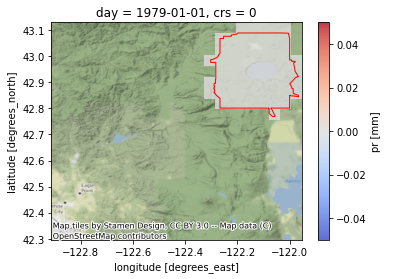

In [58]:
fig, ax = plt.subplots()

crater_lake_precip.isel(day=0).plot(ax=ax, cmap = 'coolwarm', alpha=0.8)
crater_lake_gdf.plot(ax=ax, facecolor='none', edgecolor='r')
cx.add_basemap(ax, crs=met_crs)

That looks effective ... might need to fixt that geometry for including some weird blip on the bottom left ...

Let's go for a timeseries ...

In [67]:
crater_lake_mean_precip = crater_lake_precip.mean(dim=['lat','lon'])

Text(0, 0.5, 'Date')

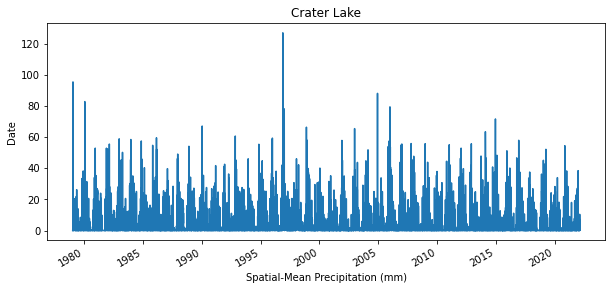

In [105]:
fig, ax = plt.subplots(figsize=(10,4))
crater_lake_mean_precip.plot(ax=ax)
ax.set_title('Crater Lake')
ax.set_xlabel('Spatial-Mean Precipitation (mm)')
ax.set_ylabel('Date')

That's promising ... what if I turn it into total monthly precip?

In [79]:
crater_lake_mean_precip_monthly_sum = crater_lake_mean_precip.resample(day='M').sum()

Text(0.5, 1.0, 'Crater Lake')

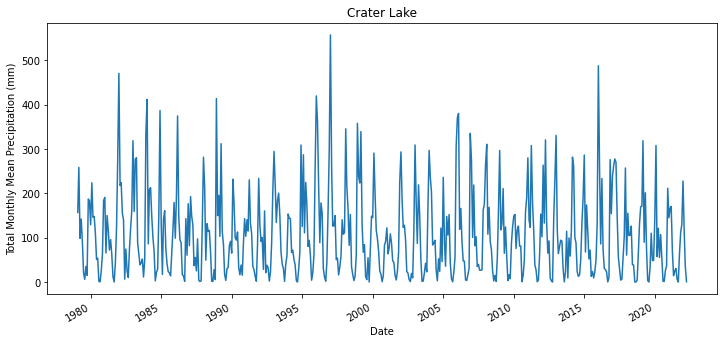

In [108]:
fig, ax = plt.subplots(figsize=(12,5))
crater_lake_mean_precip_monthly_sum.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Total Monthly Mean Precipitation (mm)')
ax.set_title('Crater Lake')

In [85]:
crater_lake_visits = nat_park_visits.sel(park='Crater Lake')

In [88]:
crater_lake_visits.time

<xarray.DataArray 'time' (time: 505)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', ..., '2020-11-01T00:00:00.000000000',
       '2020-12-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
    park     <U11 'Crater Lake'

In [96]:
crater_lake_visits.var()

<xarray.Dataset>
Dimensions:                  ()
Coordinates:
    park                     <U11 'Crater Lake'
Data variables:
    Day Visits               float64 1.893e+09
    Recreation Visitors      float64 1.895e+09
    Non-Recreation Visitors  float64 7.095e+06
    Concession Lodging       float64 9.562e+06
    Tent Campers             float64 1.233e+06
    RV Campers               float64 1.514e+06
    Concession Camping       float64 2.238e+07
    Backcountry Campers      float64 2.695e+04
    Misc Campers             float64 0.0
    Total Overnight Stays    float64 6.723e+07

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

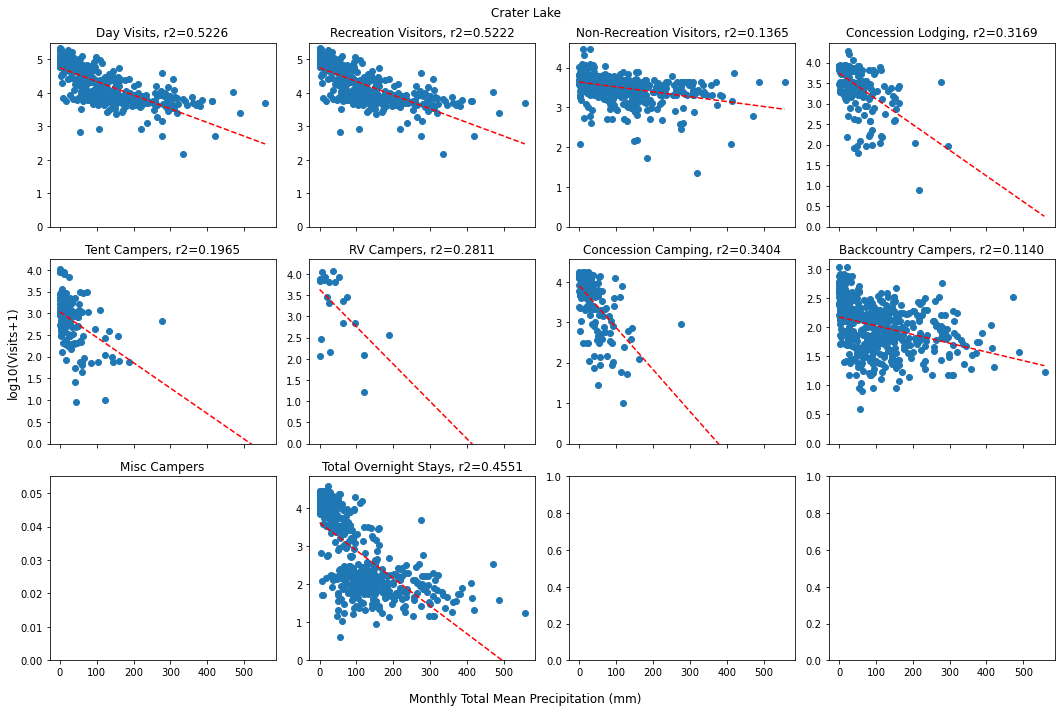

In [142]:
fig, axs = plt.subplots(3,4, figsize=(15,10), sharex=True)

ax_list = axs.ravel()

x = crater_lake_mean_precip_monthly_sum.sel(day=slice('1979-01','2021-01')).values
x_min = x.min()
x_max = x.max()

for i, var in enumerate(crater_lake_visits.var()):
    ax = ax_list[i]

    y = np.log10(crater_lake_visits[var].values+1)
    #y = crater_lake_visits[var].values
    idx = np.where(y>0)[0]
    x_sel = x[idx].reshape((-1, 1))
    y_sel = y[idx]

    try:
        model = LinearRegression().fit(x_sel, y_sel)
        r_sq = model.score(x_sel, y_sel)

        x_new = np.arange(x_min, x_max).reshape((-1,1))
        y_new = model.predict(x_new)
    except:
        pass

    ax.scatter(x_sel, y_sel)
    try:
        ax.plot(x_new, y_new, linestyle='--', color='r')
        ax.set_title(f'{var}, r2={r_sq:.4f}')

        model = None
        r_sq = None
        x_new = None
        y_new = None
    except:
        ax.set_title(f'{var}')

    ax.set_ylim(bottom=0)

    

fig.suptitle('Crater Lake')
fig.supylabel('log10(Visits+1)')
fig.supxlabel('Monthly Total Mean Precipitation (mm)')

plt.tight_layout()

Interesting ... nothing that jumps out but some of those could be promising ... do need to keep in mind that because this data is not normal, we can't do a linear regression test for slope significance. Perhaps a nonparametric linear regression wou;ld make these even better. (https://www.statsdirect.com/help/nonparametric_methods/nonparametric_regression.htm)

I did check with and without log for both x and y, and just putting log on the y seems to be the best combination.

Will note that maybe removing some outliers would improve this further ... looking at Tent Campers and Concession Camping.

Something like this then might make SPI worthwhile to contrast.

Let's check temperature for now.

In [146]:
crater_lake_tmax = wrangle.clip_xarray(tmax_da, crater_lake_gdf)
crater_lake_tmin = wrangle.clip_xarray(tmin_da, crater_lake_gdf)

In [153]:
# going to convert these from Kelvin to Celsius
crater_lake_mean_tmax = crater_lake_tmax.mean(dim=['lat','lon'])-273.15
crater_lake_mean_tmin = crater_lake_tmin.mean(dim=['lat','lon'])-273.15

Text(0.5, 1.0, 'Crater Lake')

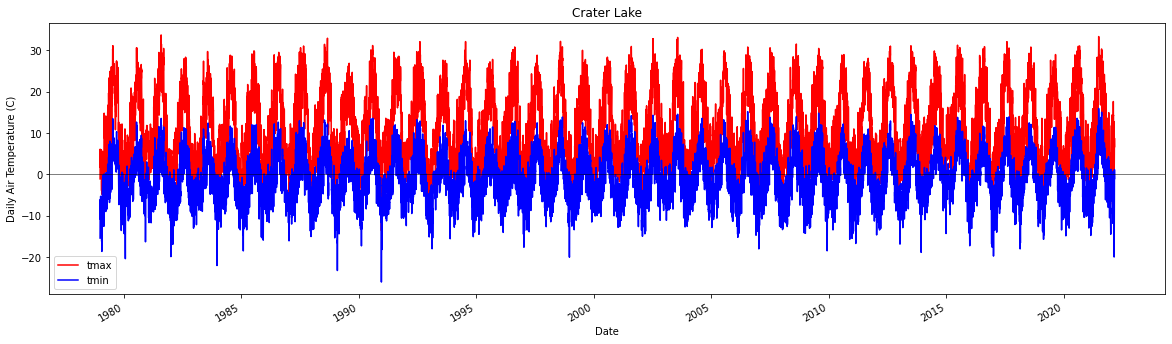

In [156]:
fig, ax = plt.subplots(figsize=(20,5))

crater_lake_mean_tmax.plot(ax=ax, color='r', label='tmax')
crater_lake_mean_tmin.plot(ax=ax, color='b', label='tmin')
ax.legend()
ax.set_ylabel('Daily Air Temperature (C)')
ax.axhline(0, color='k', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_title('Crater Lake')

Good sanity check to make sure tmax is always grater than tmin, we good.

In [160]:
# going to use mean on these cause I want to be sensitive to outliers.
crater_lake_monthly_mean_tmax = crater_lake_mean_tmax.resample(day='M').mean()
crater_lake_monthly_mean_tmin = crater_lake_mean_tmin.resample(day='M').mean()

Text(0.5, 1.0, 'Crater Lake')

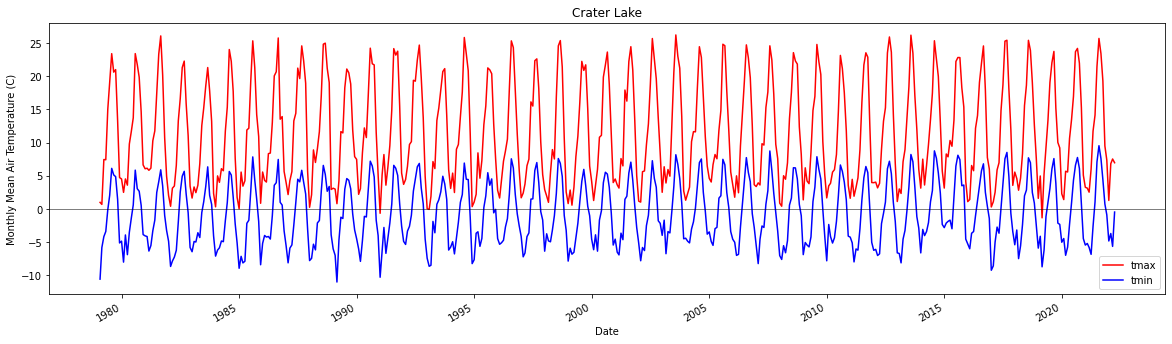

In [161]:
fig, ax = plt.subplots(figsize=(20,5))

crater_lake_monthly_mean_tmax.plot(ax=ax, color='r', label='tmax')
crater_lake_monthly_mean_tmin.plot(ax=ax, color='b', label='tmin')
ax.legend()
ax.set_ylabel('Monthly Mean Air Temperature (C)')
ax.axhline(0, color='k', linewidth=0.5)
ax.set_xlabel('Date')
ax.set_title('Crater Lake')

Still doing good keeping tmin below tmax it seems.

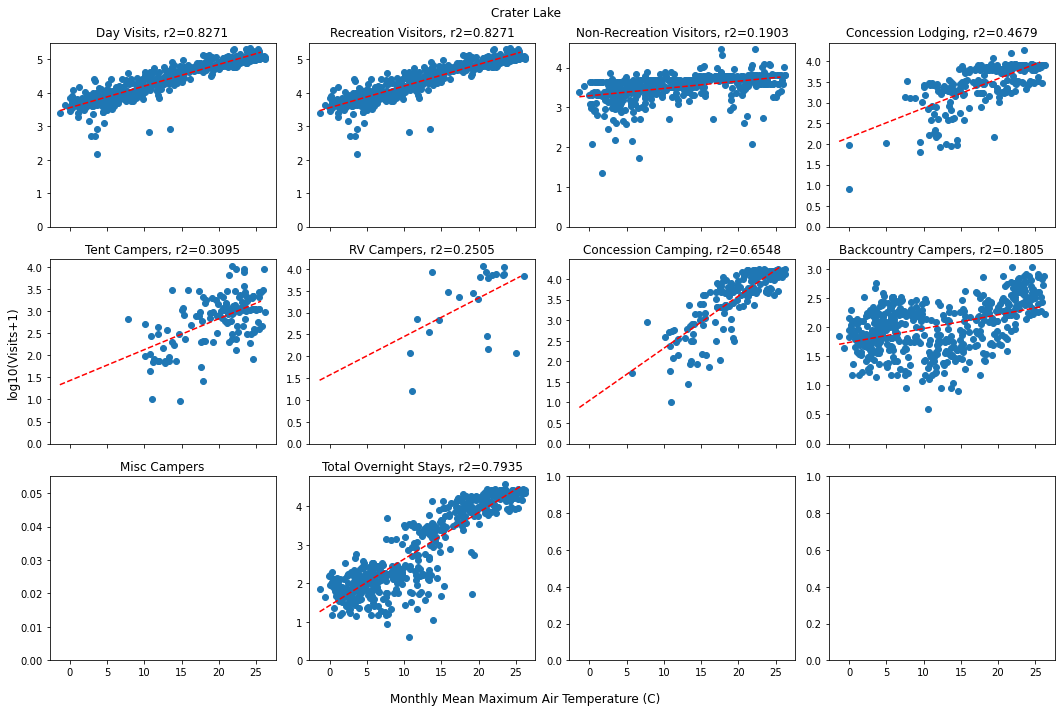

In [164]:
fig, axs = plt.subplots(3,4, figsize=(15,10), sharex=True)

ax_list = axs.ravel()

x = crater_lake_monthly_mean_tmax.sel(day=slice('1979-01','2021-01')).values
x_min = x.min()
x_max = x.max()

for i, var in enumerate(crater_lake_visits.var()):
    ax = ax_list[i]

    y = np.log10(crater_lake_visits[var].values+1)
    #y = crater_lake_visits[var].values
    idx = np.where(y>0)[0]
    x_sel = x[idx].reshape((-1, 1))
    y_sel = y[idx]

    try:
        model = LinearRegression().fit(x_sel, y_sel)
        r_sq = model.score(x_sel, y_sel)

        x_new = np.arange(x_min, x_max).reshape((-1,1))
        y_new = model.predict(x_new)
    except:
        pass

    ax.scatter(x_sel, y_sel)
    try:
        ax.plot(x_new, y_new, linestyle='--', color='r')
        ax.set_title(f'{var}, r2={r_sq:.4f}')

        model = None
        r_sq = None
        x_new = None
        y_new = None
    except:
        ax.set_title(f'{var}')

    ax.set_ylim(bottom=0)

    

fig.suptitle('Crater Lake')
fig.supylabel('log10(Visits+1)')
fig.supxlabel('Monthly Mean Maximum Air Temperature (C)')

plt.tight_layout()

Now that I like. If I do some filtering could probably be even better.

I wonder about SPEI ... or perhaps PDSI

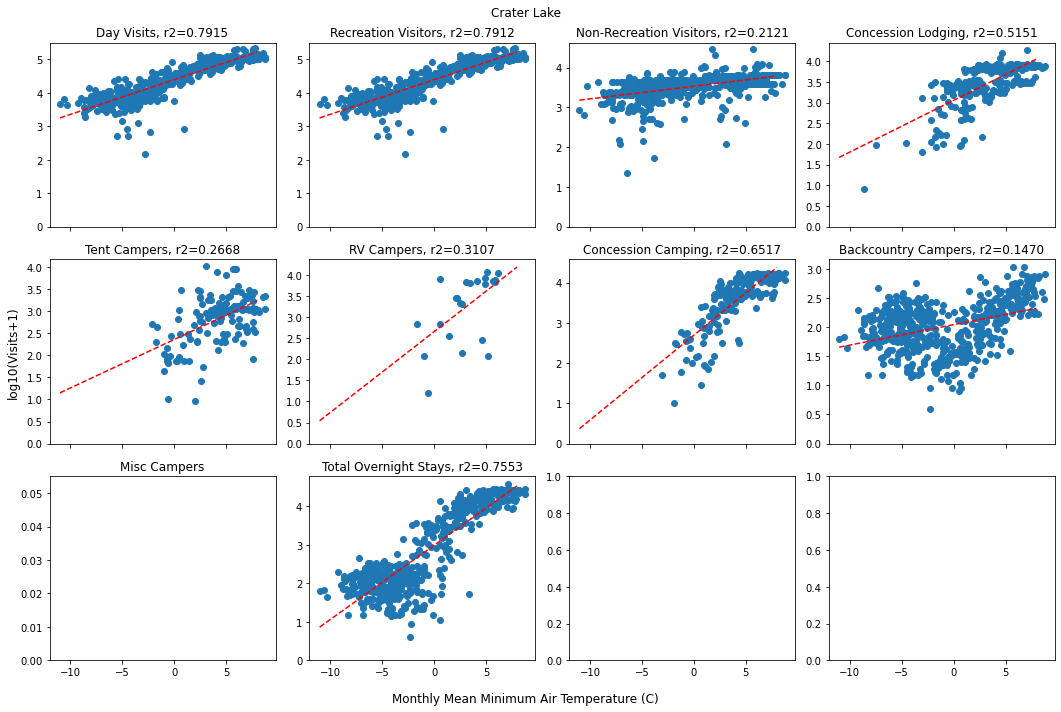

In [290]:
fig, axs = plt.subplots(3,4, figsize=(15,10), sharex=True)

ax_list = axs.ravel()

x = crater_lake_monthly_mean_tmin.sel(day=slice('1979-01','2021-01')).values
x_min = x.min()
x_max = x.max()

for i, var in enumerate(crater_lake_visits.var()):
    ax = ax_list[i]

    y = np.log10(crater_lake_visits[var].values+1)
    #y = crater_lake_visits[var].values
    idx = np.where(y>0)[0]
    x_sel = x[idx].reshape((-1, 1))
    y_sel = y[idx]

    try:
        model = LinearRegression().fit(x_sel, y_sel)
        r_sq = model.score(x_sel, y_sel)

        x_new = np.arange(x_min, x_max).reshape((-1,1))
        y_new = model.predict(x_new)
    except:
        pass

    ax.scatter(x_sel, y_sel)
    try:
        ax.plot(x_new, y_new, linestyle='--', color='r')
        ax.set_title(f'{var}, r2={r_sq:.4f}')

        model = None
        r_sq = None
        x_new = None
        y_new = None
    except:
        ax.set_title(f'{var}')

    ax.set_ylim(bottom=0)

    

fig.suptitle('Crater Lake')
fig.supylabel('log10(Visits+1)')
fig.supxlabel('Monthly Mean Minimum Air Temperature (C)')

plt.tight_layout()

This is pretty good too.

Let's wrap the individual axis plotting into a single function to make life easier then do this for all the parks in ONE BIG PLOT!!

In [355]:
def scatter_linregress(x:np.ndarray, y:np.ndarray, ax=None, title_var=None):
    """Create a scatter between x and y and perform linear regression.

    Parameters
    ----------
    x, y : np.ndarray
        1D data to plot against each other with an equal number of values each.
    ax : matplotlib axis, (optional)
        Where to plot the scatter plot. One will be created with default settings
        if none is provided.
    title_var : str, (optional)
        Additional specification for title label. R-squared value will be displayed
        in the title regardless.

    Returns
    -------
    ax
        Axis object containing created plot.
    """

    if ax is None:
        __, ax = plt.subplots()

    if len(x) != len(y):
        raise Exception('x and y do not have an equal number of points, they cannot be paired for scatter')

    x_reshape = x.reshape((-1, 1))

    model = LinearRegression().fit(x_reshape, y)
    #model.fit(x_reshape.squeeze(), y.squeeze())
    r_sq = model.score(x_reshape, y)

    x_new = np.arange(x.min(), x.max()).reshape((-1,1))
    y_new = model.predict(x_new)

    ax.scatter(x, y)
    ax.plot(x_new, y_new, linestyle='--', color='r')

    if title_var and isinstance(title_var, str):
        ax.set_title(f'{title_var}, '+r'$R^2$'+f' = {r_sq:.3f}')
    else:
        ax.set_title(r'$R^2$'+f' = {r_sq:.3f}')

    return ax

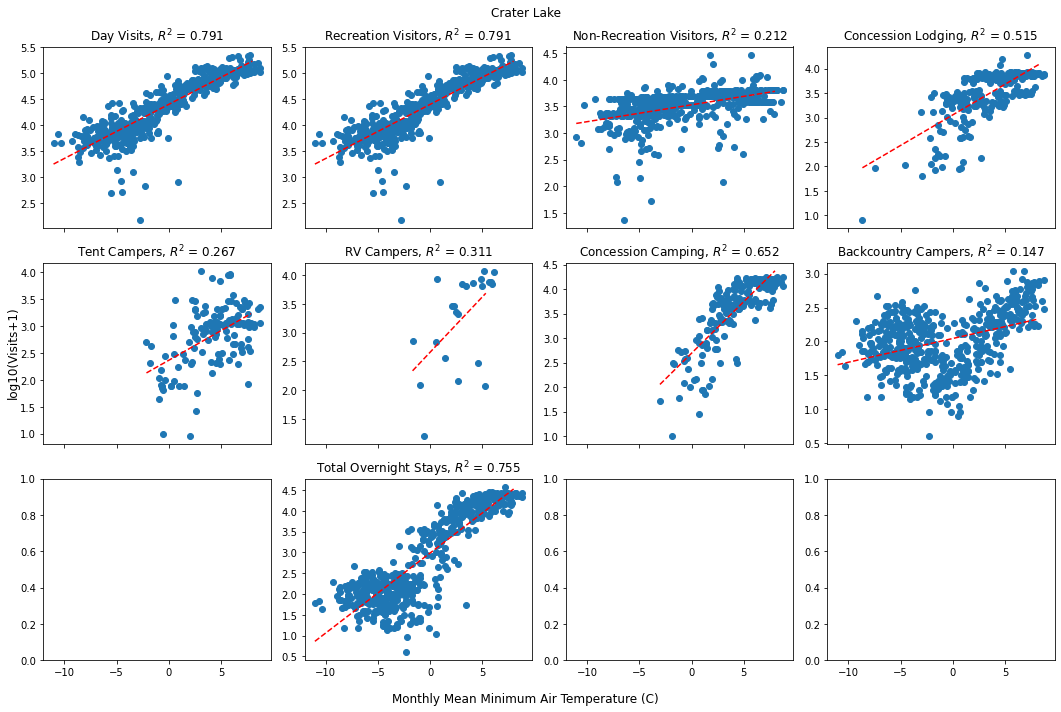

In [356]:
fig, axs = plt.subplots(3,4, figsize=(15,10), sharex=True)

ax_list = axs.ravel()

x = crater_lake_monthly_mean_tmin.sel(day=slice('1979-01','2021-01')).values
x_min = x.min()
x_max = x.max()

for i, var in enumerate(crater_lake_visits.var()):
    ax = ax_list[i]

    y = np.log10(crater_lake_visits[var].values+1)
    #y = crater_lake_visits[var].values
    idx = np.where(y>0)[0]
    x_sel = x[idx]
    y_sel = y[idx]

    try:
        scatter_linregress(x_sel,y_sel,ax=ax,title_var=var)
    except:
        pass

fig.suptitle('Crater Lake')
fig.supylabel('log10(Visits+1)')
fig.supxlabel('Monthly Mean Minimum Air Temperature (C)')

plt.tight_layout()

Let's also get a basic threshold function going.

In [184]:
a = np.arange(0,6)
b = np.arange(3,6)
c = np.arange(2,5)

In [185]:
np.intersect1d(np.intersect1d(a,b), c)

array([3, 4])

In [195]:
def threshold_filtered_pair(x:np.ndarray, y:np.ndarray, minx=None, maxx=None, miny=None, maxy=None):
    """Filter for x and y based on a threshold to either, assuming 1:1 mapping.

    Parameters 
    ----------
    x, y : np.ndarray
        Array of values that assumes x and y are mapped 1:1 and ordered, such that 
        the first element of x maps to the first element of y, and so forth.
    minx, miny : float, (optional)
        Minimum inclusive threshold for x and y, respectively.
    maxx,y maxy : float, (optional)
        Maximum inclusive threshold for x and y, respectively.

    Returns
    -------
    x, y : np.ndarray
        x and y filtered based on the provided thresholds, respectively.
    """
    # for each of these, if a threshold isn't provided then
    # we need to have an array that contains all of the indices
    if minx:
        x_above_floor = np.where(x>=minx)[0]
    else:
        x_above_floor = np.arange(0, len(x))

    if maxx:
        x_below_ceiling = np.where(x<=maxx)[0]
    else:
        x_below_ceiling = np.arange(0, len(x))

    if miny:
        y_above_floor = np.where(y>=miny)[0]
    else:
        y_above_floor = np.arange(0, len(y))
    
    if maxy:
        y_below_ceiling = np.where(y<=maxy)[0]
    else:
        y_below_ceiling = np.arange(0, len(y))

    # find common indices to select out
    x_filter_idx = np.intersect1d(x_above_floor, x_below_ceiling)
    y_filter_idx = np.intersect1d(y_above_floor, y_below_ceiling)
    filter_idx = np.intersect1d(x_filter_idx, y_filter_idx)

    return x[filter_idx], y[filter_idx]

In [197]:
a = np.arange(0,6)
b = np.arange(6,12)

threshold_filtered_pair(a, b, minx=1.1, maxx=6, miny=0, maxy=10)

(array([2, 3, 4]), array([ 8,  9, 10]))

That's looking pretty good. This will be helpful.

Let's get all the data clipped for the parks.

In [241]:
park_met = xr.Dataset(
    coords=dict(
        park=(["park"], nat_parks),
        time=(["time"], nat_park_visits.time.values)
    )
)

t = tqdm(total=len(nat_parks))

park_precips = []
park_tmaxs = []
park_tmins = []

for i, park in enumerate(nat_parks):
    t.set_description(f'clipping {park}')
    # need to do this strange step to keep it as a GeoDataFrame
    # so that I don't loose the crs attribute since a function
    # I need requires a geodataframe, and this seems easier than
    # making a new one
    UNIT_CODE = nps_gdf['UNIT_CODE'].iloc[i]
    park_gdf = nps_gdf[nps_gdf.UNIT_CODE==UNIT_CODE]

    park_precip = wrangle.clip_xarray(precip_da, park_gdf)
    park_tmax = wrangle.clip_xarray(tmax_da, park_gdf)
    park_tmin = wrangle.clip_xarray(tmin_da, park_gdf)

    t.set_description(f'averaging {park}')
    mean_park_precip = park_precip.sel(day=slice('1979-01','2021-01')).mean(dim=['lon', 'lat'])
    # convert from Kelvin to Celsius 
    mean_park_tmax = park_tmax.sel(day=slice('1979-01','2021-01')).mean(dim=['lon', 'lat']) - 273.15
    mean_park_tmin = park_tmin.sel(day=slice('1979-01','2021-01')).mean(dim=['lon', 'lat']) - 273.15

    t.set_description(f'resampling {park}')
    monthly_total_mean_park_precip = mean_park_precip.resample(day='M').sum()
    monthly_mean_mean_park_tmax = mean_park_tmax.resample(day='M').mean()
    monthly_mean_mean_park_tmin = mean_park_tmin.resample(day='M').mean()

    park_precips.append(monthly_total_mean_park_precip.values)
    park_tmaxs.append(monthly_mean_mean_park_tmax.values)
    park_tmins.append(monthly_mean_mean_park_tmin.values)

    t.update()

  0%|          | 0/11 [00:00<?, ?it/s]

In [243]:
park_met['precip'] = (['park','time'], np.vstack(park_precips))
park_met['tmax'] = (['park','time'], np.vstack(park_tmaxs))
park_met['tmin'] = (['park','time'], np.vstack(park_tmins))

In [248]:
park_met

<xarray.Dataset>
Dimensions:  (park: 11, time: 505)
Coordinates:
  * park     (park) object 'Crater Lake' ... 'San Juan Island National Histor...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Data variables:
    precip   (park, time) float32 157.1 258.8 98.59 142.2 ... 114.6 152.1 105.4
    tmax     (park, time) float32 0.9886 0.6835 7.446 7.414 ... 9.671 8.41 8.494
    tmin     (park, time) float32 -10.59 -5.827 -4.177 ... 3.785 3.419 3.338

And add in some metadata before I forget.

In [260]:
park_met.attrs = {
    "Description":"Meteorological data spatially averaged daily values over national parks, then resampled to monthly values.",
    "Author":"a. stein",
    "Date":"3.10.22",
    "crs used":f"{met_crs}",
    "Clipping scheme":"touching"
}
park_met

<xarray.Dataset>
Dimensions:  (park: 11, time: 505)
Coordinates:
  * park     (park) object 'Crater Lake' ... 'San Juan Island National Histor...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Data variables:
    precip   (park, time) float32 157.1 258.8 98.59 142.2 ... 114.6 152.1 105.4
    tmax     (park, time) float32 0.9886 0.6835 7.446 7.414 ... 9.671 8.41 8.494
    tmin     (park, time) float32 -10.59 -5.827 -4.177 ... 3.785 3.419 3.338
Attributes:
    Description:      Meteorological data spatially averaged daily values ove...
    Author:           a. stein
    Date:             3.10.22
    crs used:         EPSG:4326
    Clipping scheme:  touching

In [263]:
park_met['precip'].attrs = {
    "Long name":"Resampled Total Monthly Precipitation, Spatially Averaged",
    "Units":"mm"
}
park_met['precip']

<xarray.DataArray 'precip' (park: 11, time: 505)>
array([[157.12968 , 258.78284 ,  98.59063 , ..., 211.59375 , 144.86719 ,
        166.41252 ],
       [ 36.588234,  30.917646,  35.91765 , ...,  51.805885,  16.617647,
         20.97647 ],
       [ 66.05485 , 252.80646 ,  94.612915, ..., 282.39032 , 204.74841 ,
        242.5613  ],
       ...,
       [158.30002 , 341.74286 ,  63.3     , ..., 240.18573 , 203.11429 ,
        348.88574 ],
       [ 91.758736, 308.91428 , 139.13968 , ..., 369.5127  , 276.79523 ,
        324.27298 ],
       [ 44.6     ,  74.36666 ,  25.900002, ..., 114.63333 , 152.06665 ,
        105.38334 ]], dtype=float32)
Coordinates:
  * park     (park) object 'Crater Lake' ... 'San Juan Island National Histor...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Attributes:
    Long name:  Resampled Total Monthly Precipitation, Spatially Averaged
    Units:      mm

In [265]:
park_met['tmax'].attrs = {
    "Long name":"Resampled Monthly Average Maximum Daily Temperature, Spatially Averaged",
    "Units":"Celsius"
}
park_met['tmax']

<xarray.DataArray 'tmax' (park: 11, time: 505)>
array([[ 0.9885618 ,  0.6834902 ,  7.44572   , ...,  5.092561  ,
         3.261649  ,  3.1336267 ],
       [-2.4220974 ,  7.233199  , 13.687768  , ..., 10.06392   ,
         6.5843515 ,  7.0287514 ],
       [-6.2072253 , -0.5248805 ,  5.635548  , ...,  1.0764618 ,
         0.09547769, -0.7847477 ],
       ...,
       [ 5.9882555 ,  5.4255195 , 11.432033  , ...,  8.98191   ,
         7.408069  ,  6.744014  ],
       [-3.0192142 ,  1.6593606 ,  7.665364  , ...,  2.6924398 ,
         2.042887  ,  1.2956799 ],
       [ 4.126351  ,  7.59882   , 12.527427  , ...,  9.670564  ,
         8.409685  ,  8.494089  ]], dtype=float32)
Coordinates:
  * park     (park) object 'Crater Lake' ... 'San Juan Island National Histor...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Attributes:
    Long name:  Resampled Monthly Average Maximum Daily Temperature, Spatiall...
    Units:      Celsius

In [266]:
park_met['tmin'].attrs = {
    "Long name":"Resampled Monthly Average Minimum Daily Temperature, Spatially Averaged",
    "Units":"Celsius"
}
park_met['tmin']

<xarray.DataArray 'tmin' (park: 11, time: 505)>
array([[-10.587445  ,  -5.82661   ,  -4.1767116 , ...,  -4.4691052 ,
         -5.450297  ,  -5.2101736 ],
       [-13.364419  ,  -1.8630186 ,   0.348493  , ...,  -1.0421488 ,
         -2.9118485 ,  -2.0188706 ],
       [-15.279443  ,  -8.970037  ,  -5.4461465 , ...,  -4.6597757 ,
         -6.049165  ,  -6.785161  ],
       ...,
       [ -3.4324844 ,  -1.1729573 ,   0.3099178 , ...,   0.53048503,
         -0.80437344,  -0.8675045 ],
       [-11.210055  ,  -6.1945024 ,  -2.860953  , ...,  -2.4069753 ,
         -3.1606917 ,  -4.3436947 ],
       [ -1.8596714 ,   1.7404796 ,   3.6817234 , ...,   3.7850058 ,
          3.4193618 ,   3.3376405 ]], dtype=float32)
Coordinates:
  * park     (park) object 'Crater Lake' ... 'San Juan Island National Histor...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
Attributes:
    Long name:  Resampled Monthly Average Minimum Daily Temperature, Spatiall...
    Units:      Celsius

Awesome. This should be a helpful dataset, I'm going to save it out real quick

In [271]:
park_met_path = '../../data/met/waor_natpark_monthly_met_1979_2021.nc'

try:
    os.remove(park_met_path)
except:
    pass

park_met.to_netcdf(park_met_path)

now it's time for ... ONE BIG PLOT!!

In [274]:
len(nat_park_visits.var())

10

In [275]:
len(nat_parks)

11

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


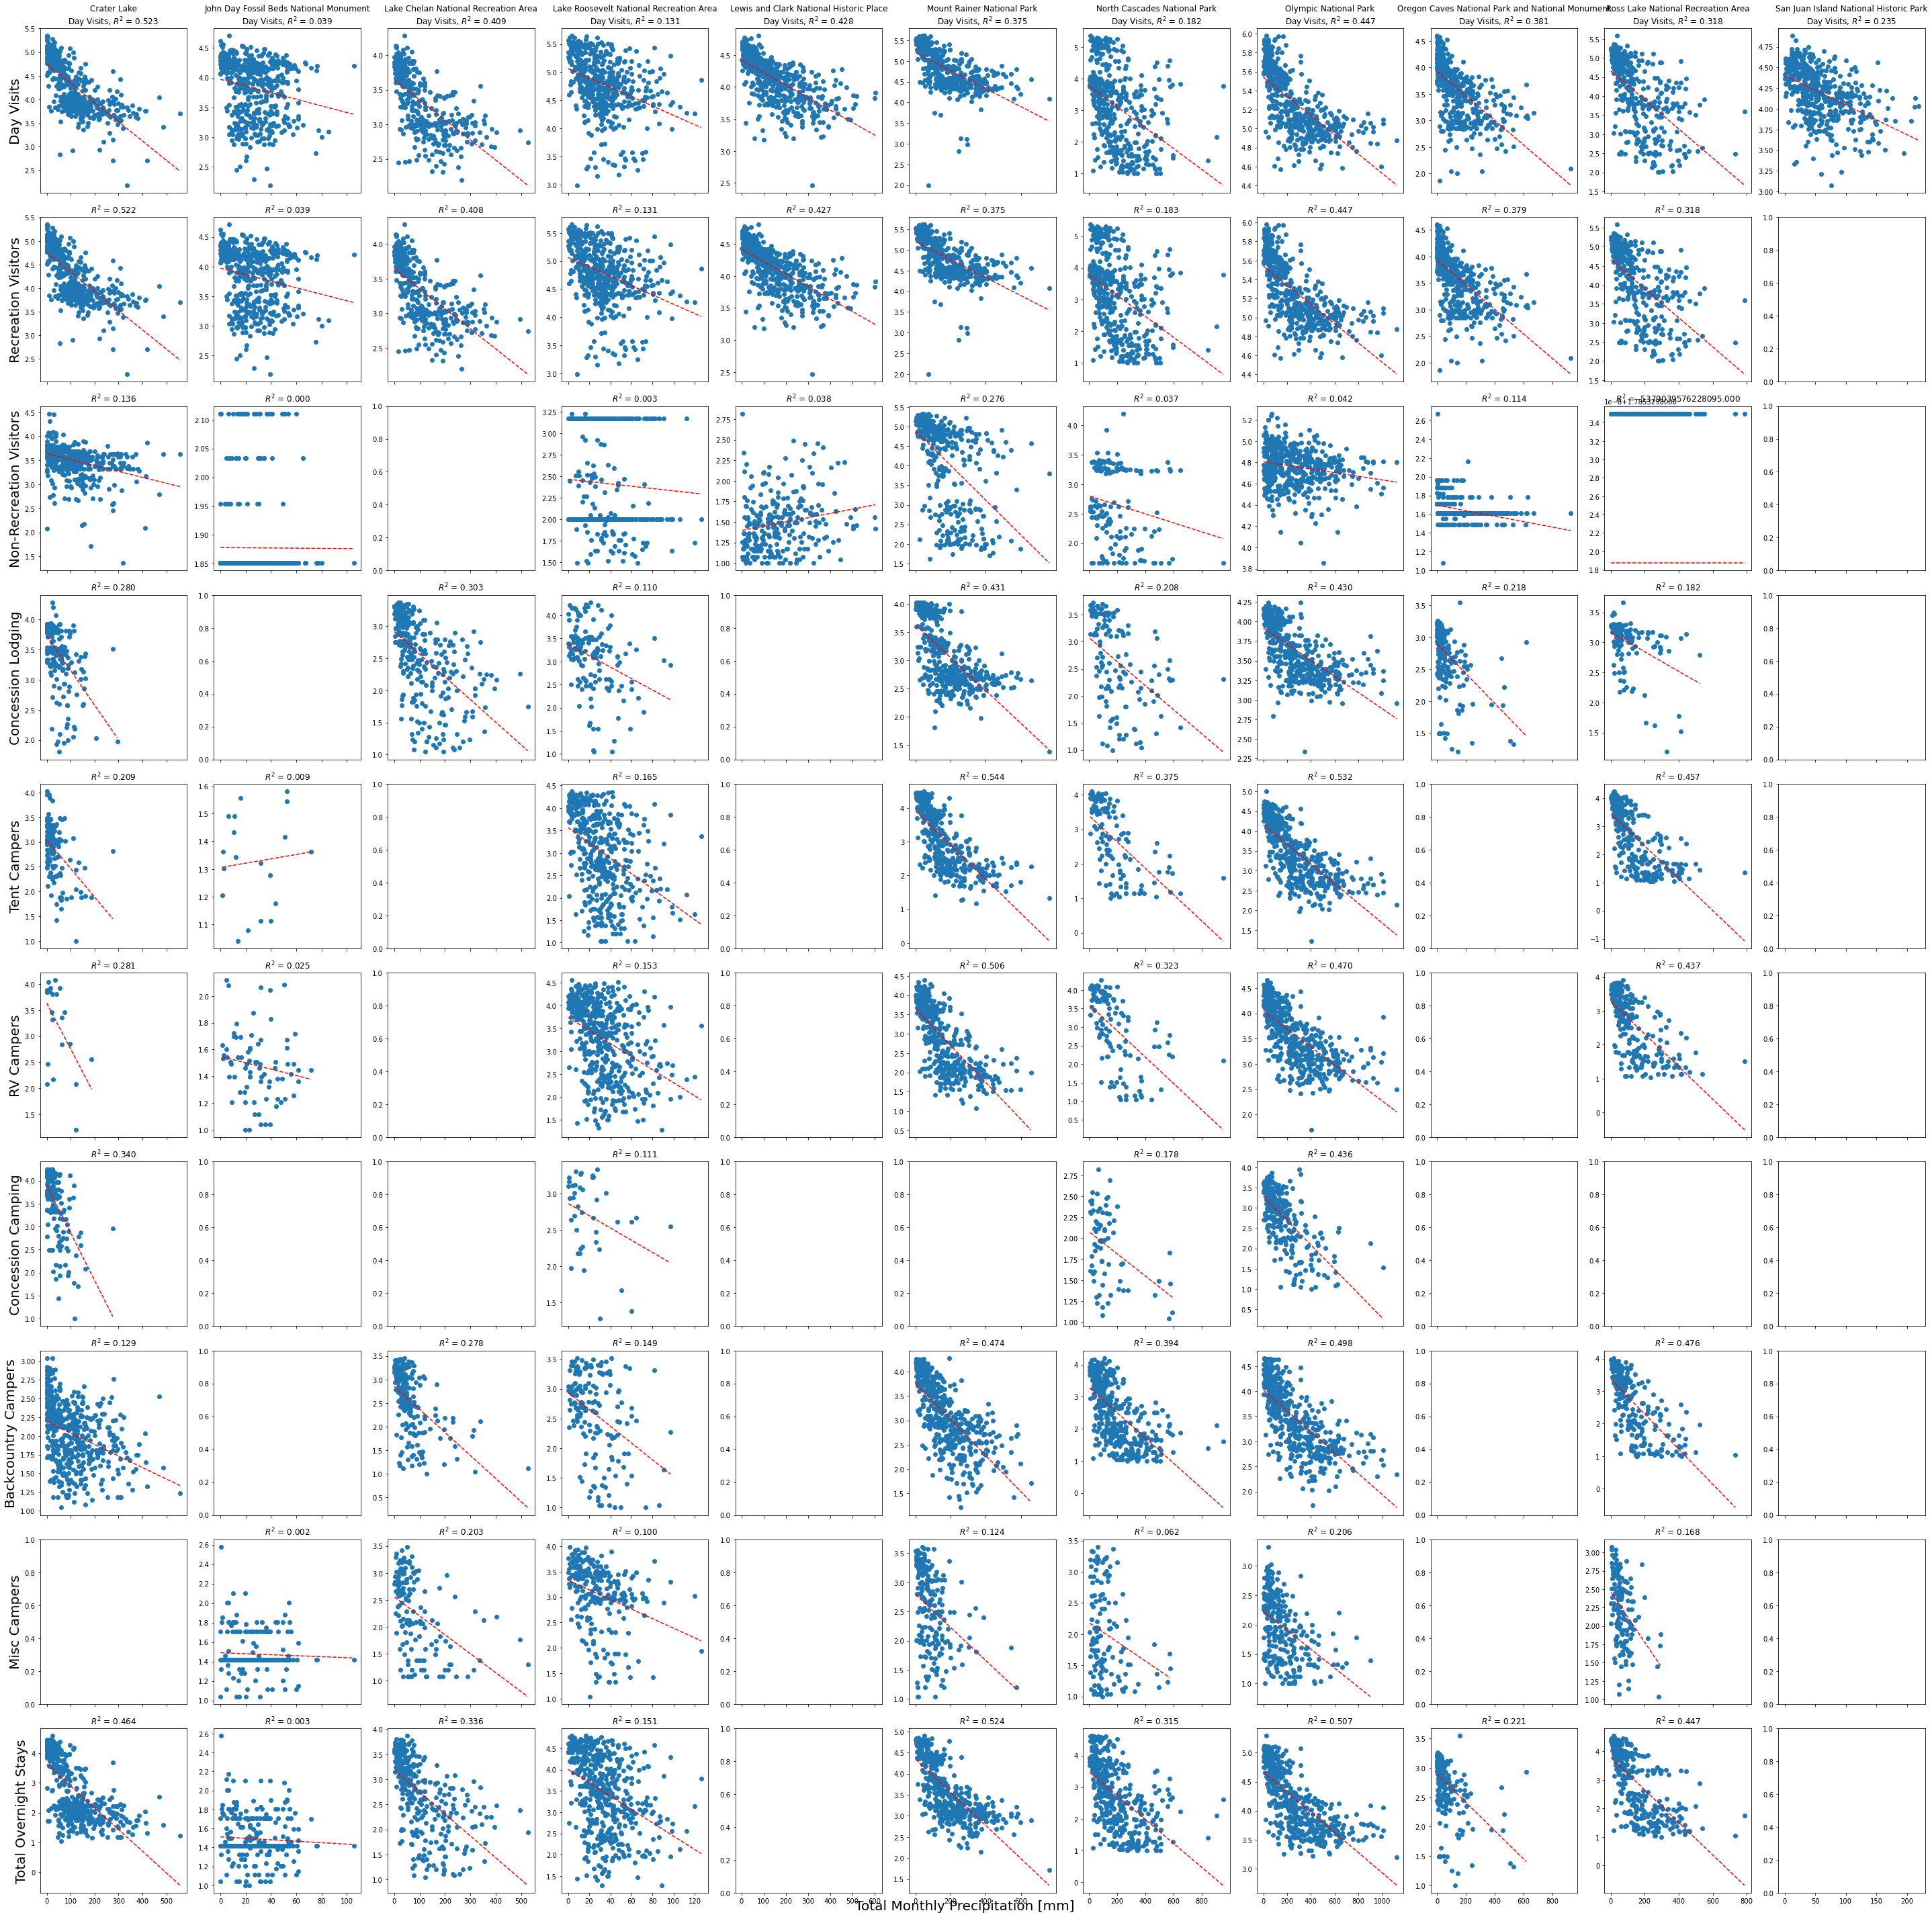

In [362]:
fig, axs = plt.subplots(10, 11, figsize=(40,40), sharex='col')

for j, park in enumerate(nat_parks):
    x = park_met.sel(park=park)['precip'].values
    for i, var in enumerate(nat_park_visits.var()):
        y = nat_park_visits.sel(park=park)[var].values
        y = np.log10(y+1)

        x_sel, y_sel = threshold_filtered_pair(x, y, miny=1)

        try:
            if i == 0:
                scatter_linregress(x_sel, y_sel, ax=axs[i,j], title_var=f'{park}\n{var}')
            else:
                scatter_linregress(x_sel, y_sel, ax=axs[i,j])
        except:
            pass

        if j == 0:
            axs[i,j].set_ylabel(var, fontsize=20)

fig.supxlabel('Total Monthly Precipitation [mm]', fontsize=20)

plt.tight_layout()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


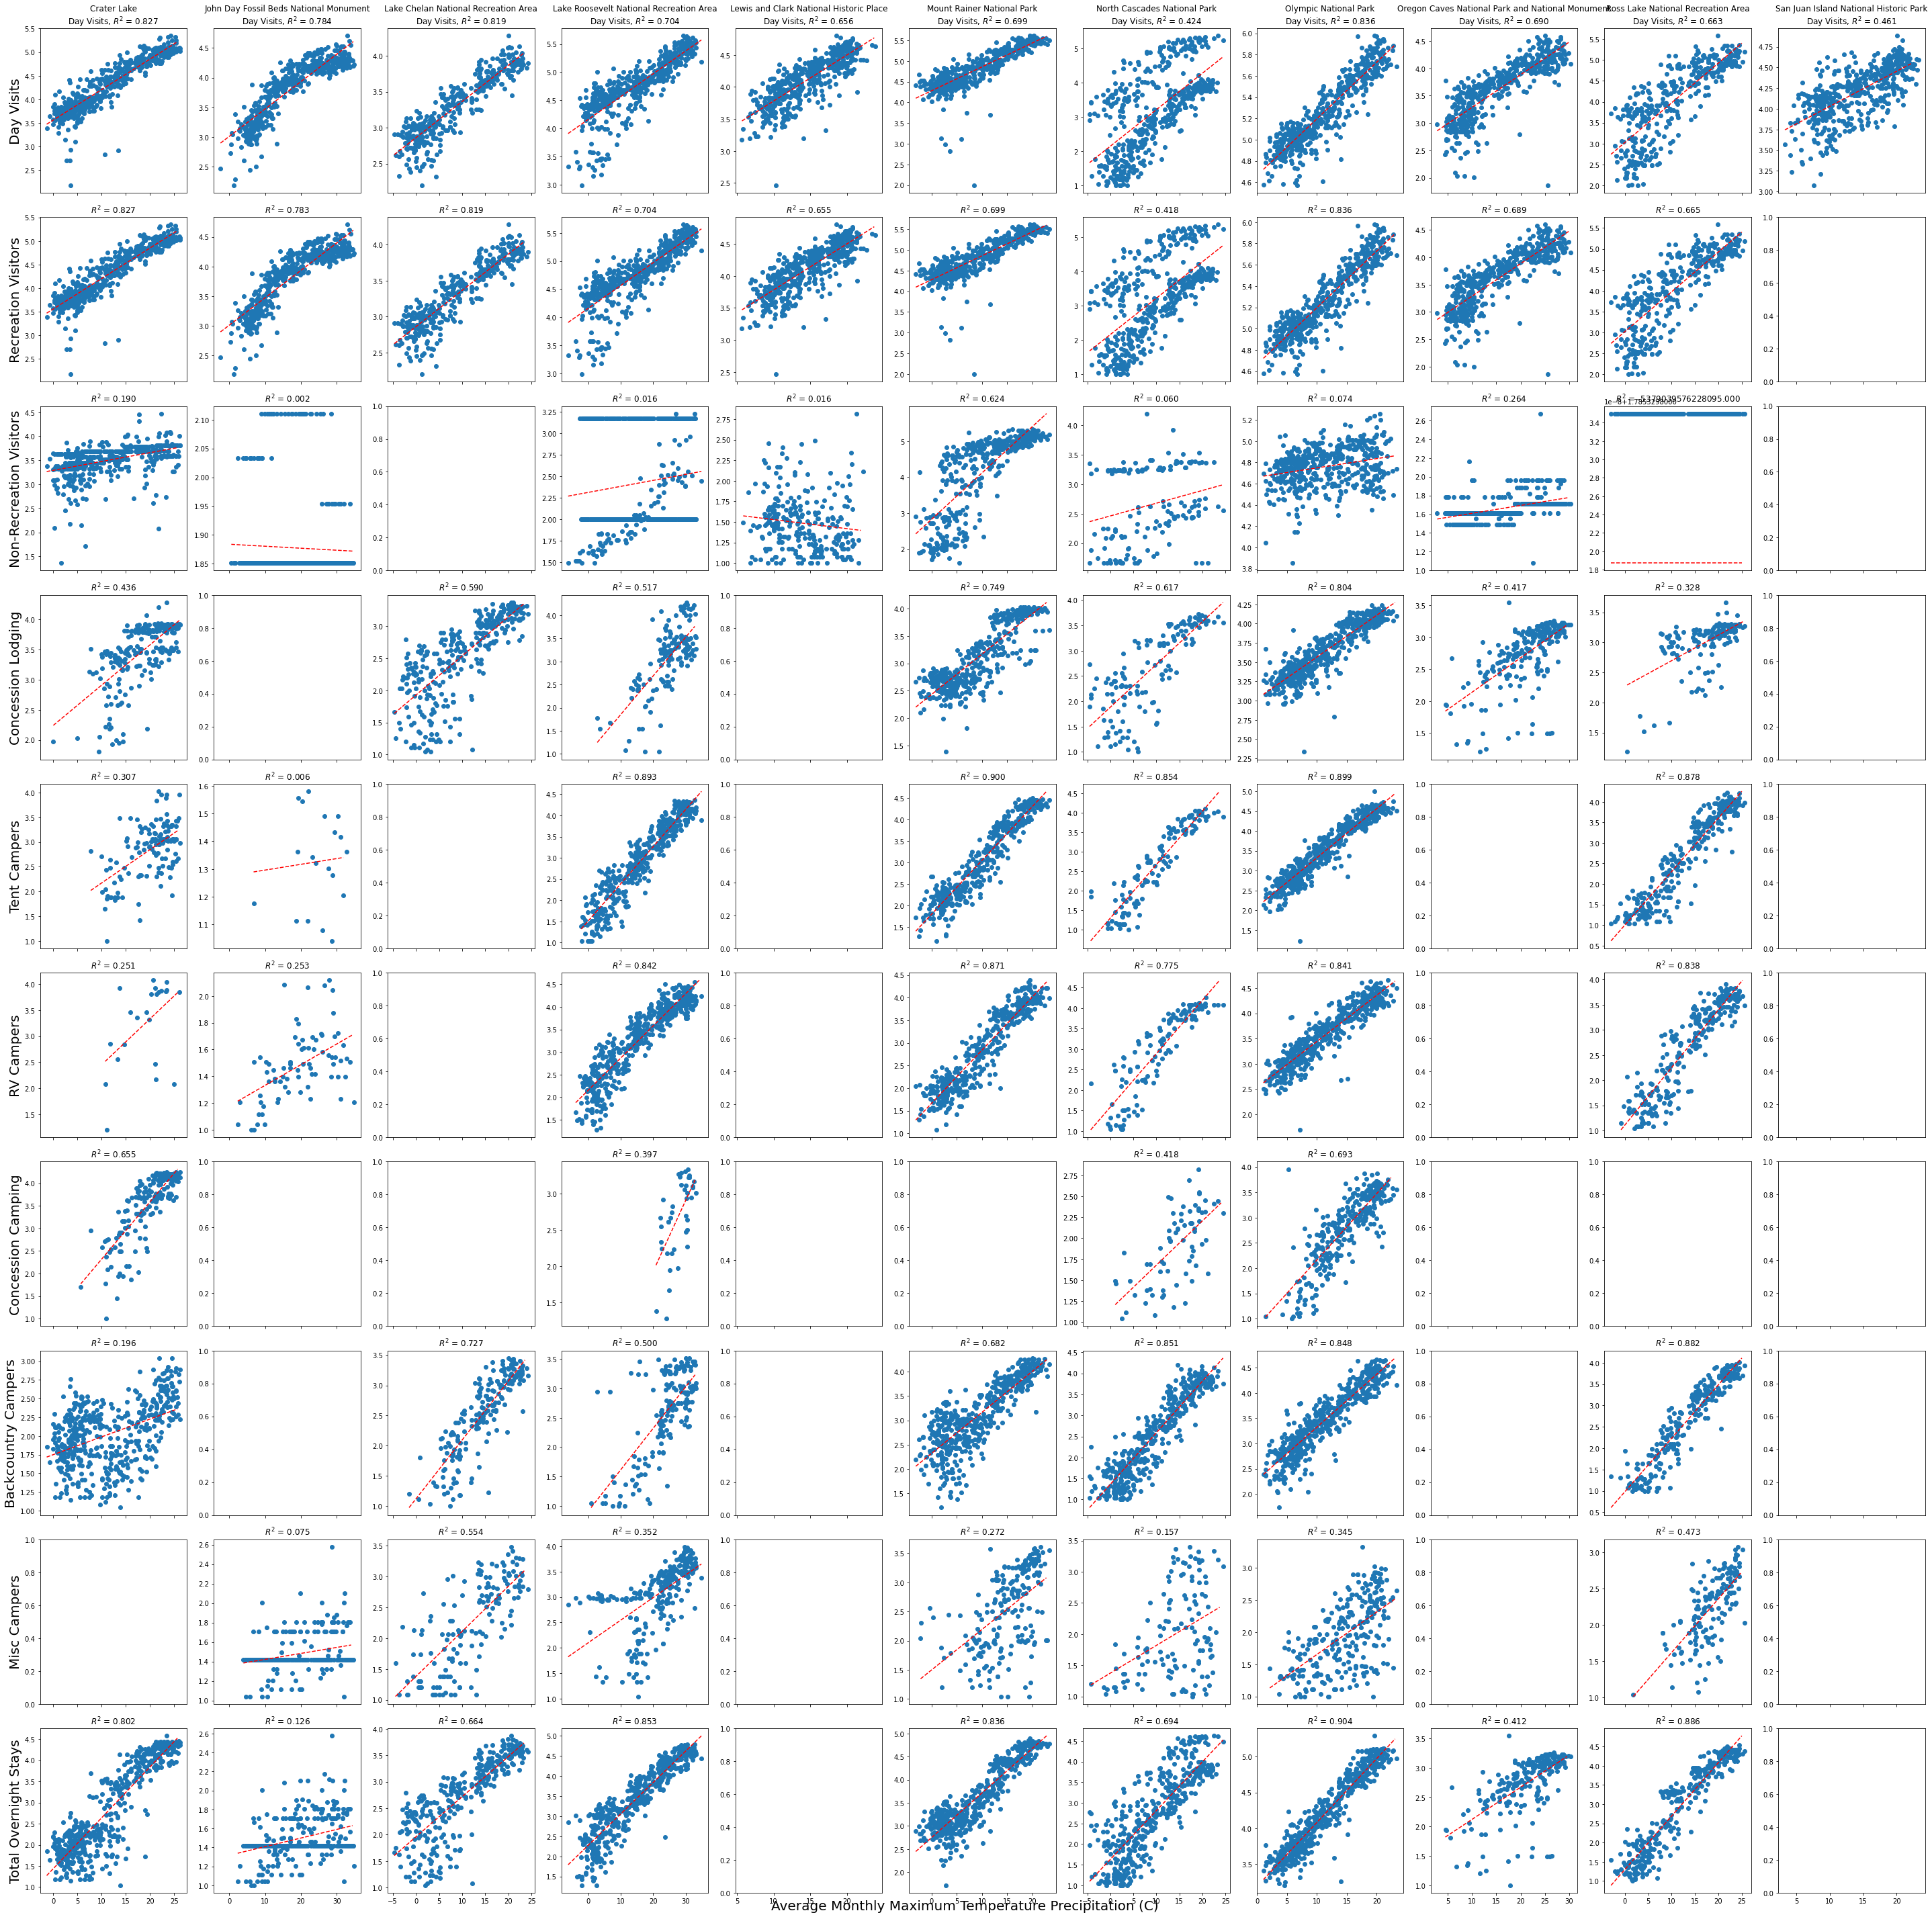

In [364]:
fig, axs = plt.subplots(10, 11, figsize=(40,40), sharex='col')

for j, park in enumerate(nat_parks):
    x = park_met.sel(park=park)['tmax'].values
    for i, var in enumerate(nat_park_visits.var()):
        y = nat_park_visits.sel(park=park)[var].values
        y = np.log10(y+1)

        x_sel, y_sel = threshold_filtered_pair(x, y, miny=1)

        try:
            if i == 0:
                scatter_linregress(x_sel, y_sel, ax=axs[i,j], title_var=f'{park}\n{var}')
            else:
                scatter_linregress(x_sel, y_sel, ax=axs[i,j])
        except:
            pass

        if j == 0:
            axs[i,j].set_ylabel(var, fontsize=20)

fig.supxlabel('Average Monthly Maximum Temperature Precipitation (C)', fontsize=20)

plt.tight_layout()

/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


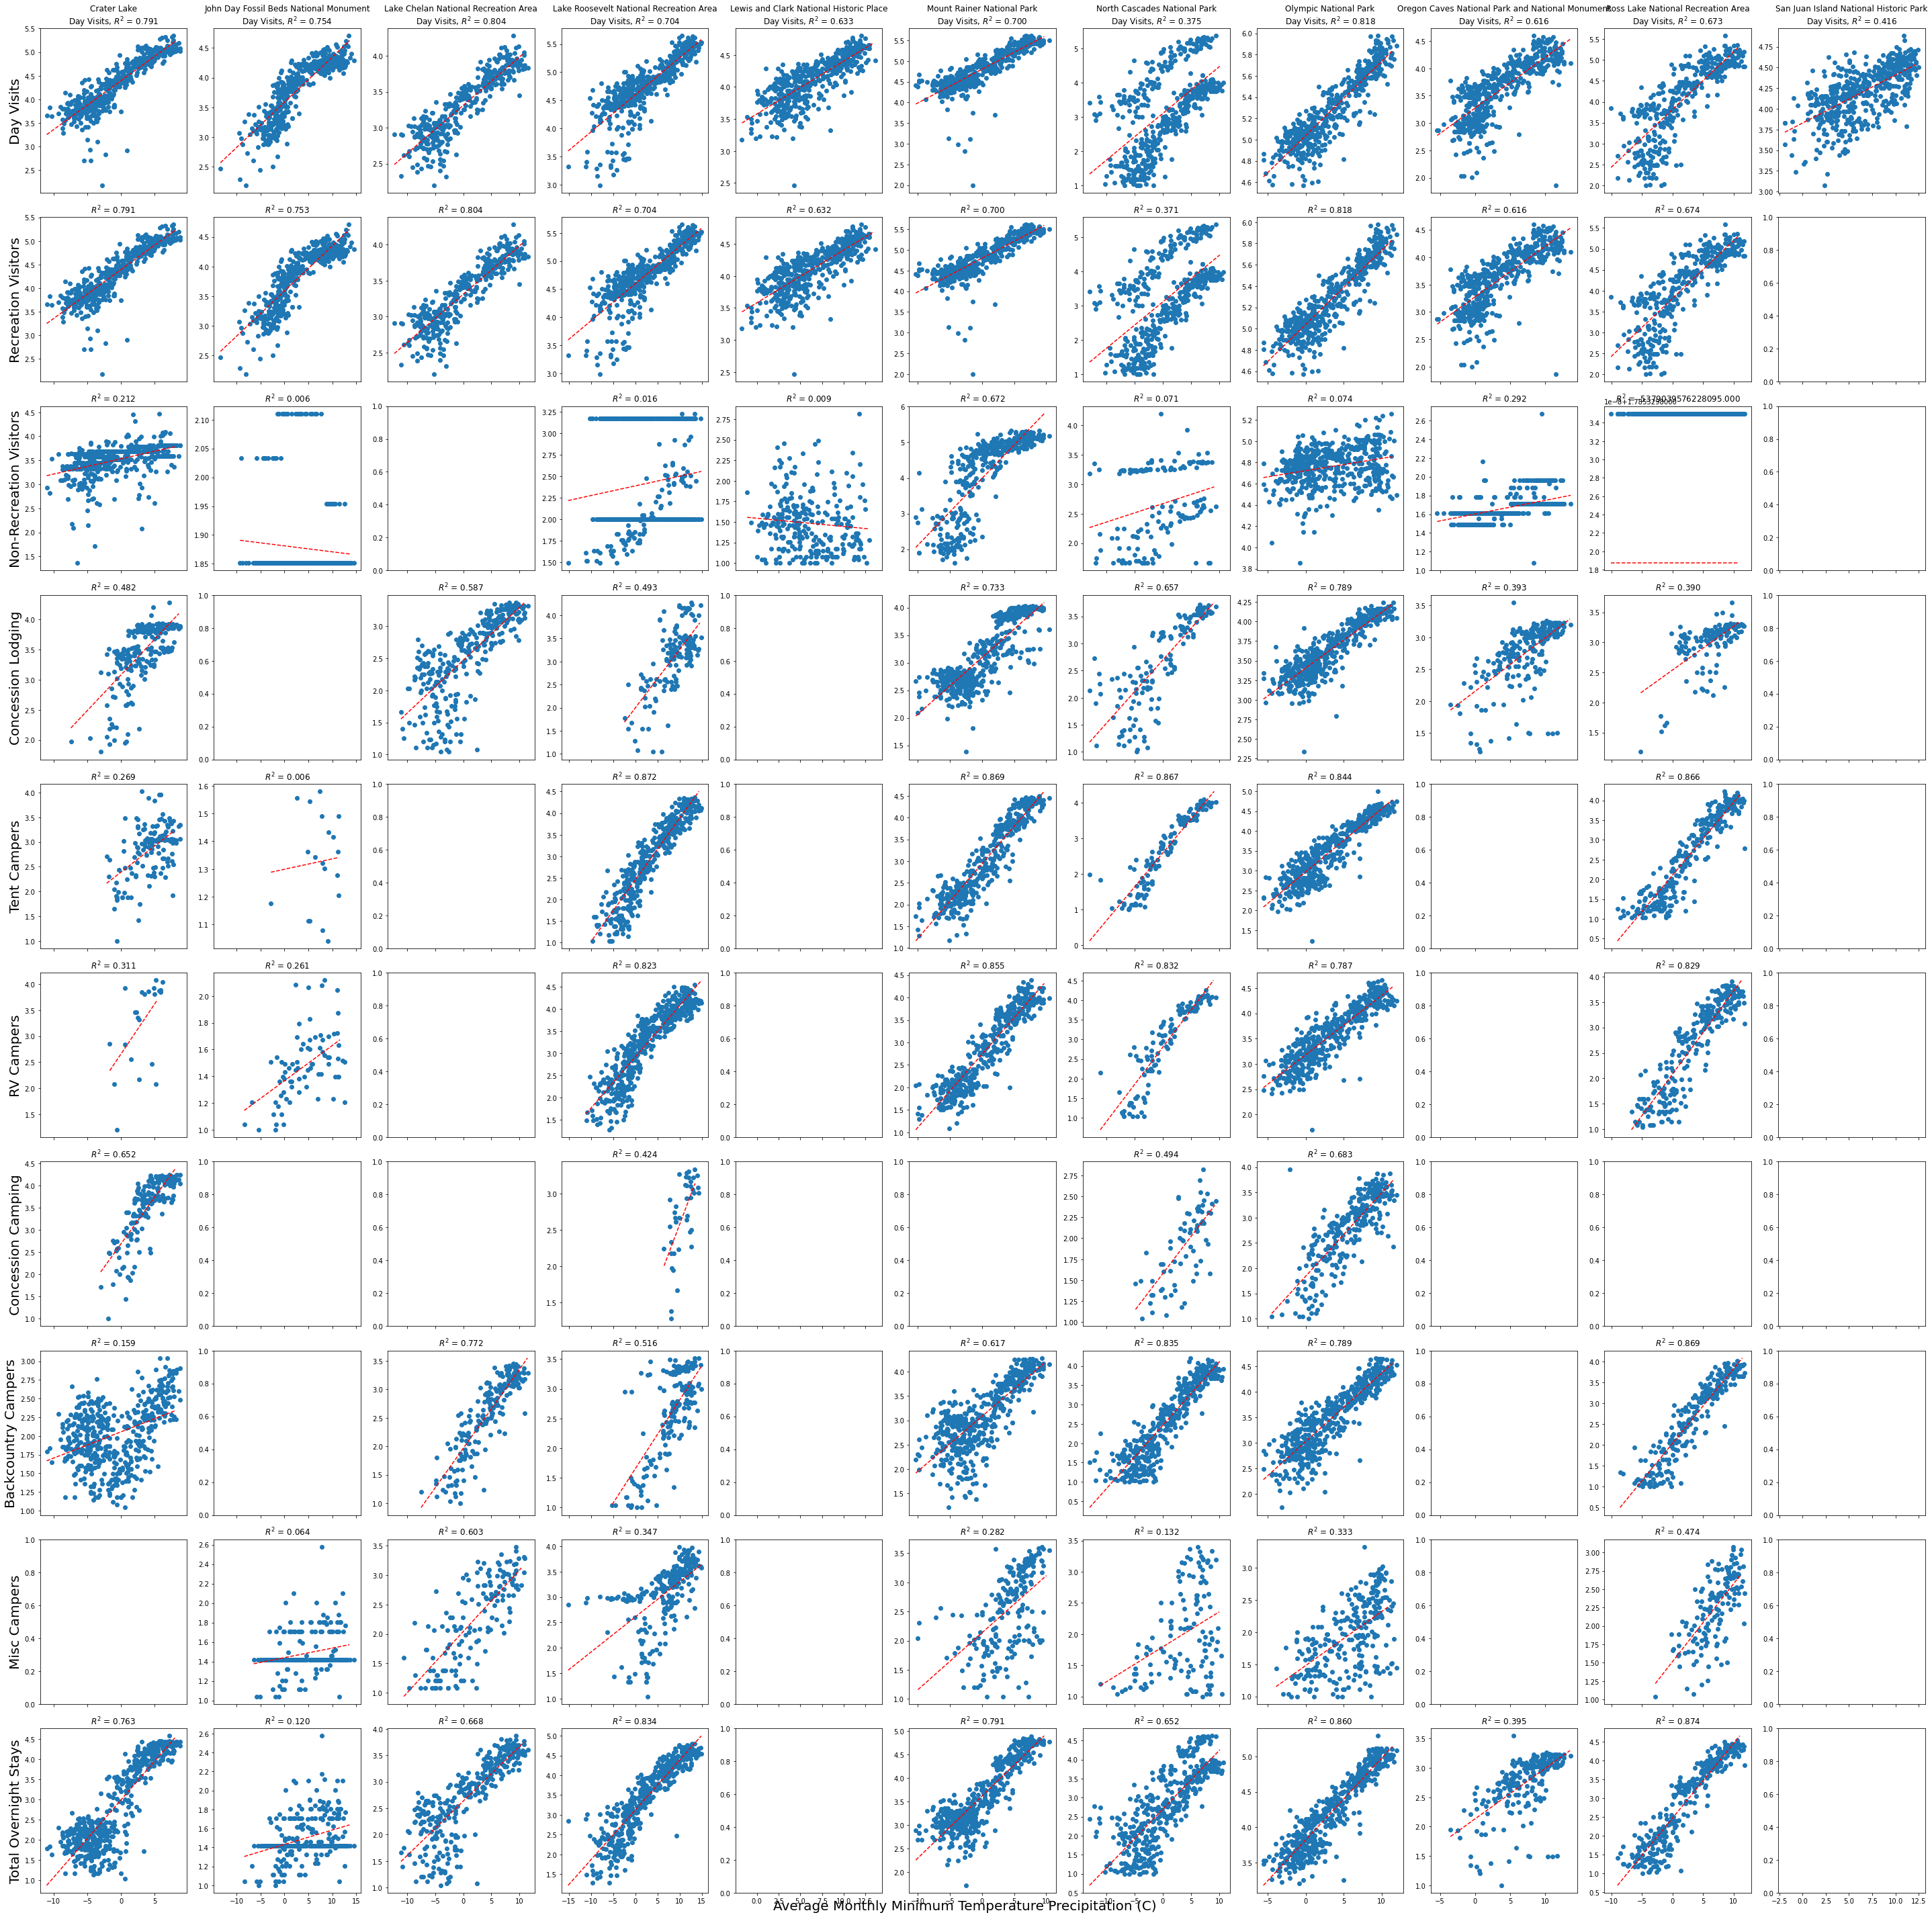

In [365]:
fig, axs = plt.subplots(10, 11, figsize=(40,40), sharex='col')

for j, park in enumerate(nat_parks):
    x = park_met.sel(park=park)['tmin'].values
    for i, var in enumerate(nat_park_visits.var()):
        y = nat_park_visits.sel(park=park)[var].values
        y = np.log10(y+1)

        x_sel, y_sel = threshold_filtered_pair(x, y, miny=1)

        try:
            if i == 0:
                scatter_linregress(x_sel, y_sel, ax=axs[i,j], title_var=f'{park}\n{var}')
            else:
                scatter_linregress(x_sel, y_sel, ax=axs[i,j])
        except:
            pass

        if j == 0:
            axs[i,j].set_ylabel(var, fontsize=20)

fig.supxlabel('Average Monthly Minimum Temperature Precipitation (C)', fontsize=20)

plt.tight_layout()